# Demonstration for pyIsofit 15.07.2021
***

Importing the package and Pandas:

In [38]:
from pyIsofit.core.fitting import IsothermFit
import pandas as pd

### 1. Fitting any model for a single dataframe
***

To fit data first create a Pandas Dataframe variable using pd.read_csv() (or json). The file must contain all datasets to be fitted (any number of datasets), with unique keys for each pressure and uptake:
    
i.e the column header for the pressure of the first dataset is 'p@0C', for the second dataset it's 'p@20C' ect.

The datasets used in this example are computational data from EPFL for CO2 and N2 on Zeolite 13X.

In [39]:
df1 = pd.read_csv('pyIsofit/Datasets for testing/Computational Data (EPFL) CO2.csv')

Next, define a list of integers (or floats) which include the temperatures of each dataset. We can input either degrees C or K - the default is C and so we do not have to specify the units. If we wanted to input temperature in Kelvin we would pass the temp_units='K' kwarg when we call the class. 

    temps = [0, 20, ...]

In [40]:
temps = [10, 40, 100]

Next, define the keys for the package to extract the data. This requires a list of strings.

    i.e key_pressures = ['p@0C', 'p@20C', '...']
        key_uptakes = ['q@0C', 'q@20C', '...']

In the example below, the pressure values corresponding to each uptake value for every dataset are identical, thus we pass the same string for all three datasets within key_pressures. 

In [41]:
key_pressures = ['Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)']
key_uptakes = ['Uptake (mmol/g)_13X_10 (°C)', 'Uptake (mmol/g)_13X_40 (°C)', 'Uptake (mmol/g)_13X_100 (°C)']

To fit this data to a model, create an instance of the IsothermFit class. This requires the user choosing a model from
the following list:

    i.e ['henry', 'mdr', 'mdr td', 'langmuir', 'langmuir linear 1', 'langmuir linear 2', 'langmuir td',
        'dsl nc', 'dsl', 'gab', 'sips', 'toth', 'toth td', 'bddt', 'bddt 2n', 'bddt 2n-1',
        'dodo', 'bet']

Notes:
      
- 'td' means temperature dependent - i.e equilibrium constant is temperature dependent { b = b0 * exp(-H/RT) }
- 'toth td' does not currently work (WIP)
- 'langmuir linear 1' is using the linear form of langmuir with axis 1/q vs. 1/p
- 'langmuir linear 2' is using the linear form of langmuir with axis p/q vs. p
- There are two forms of the bddt isotherm, both with the same parameters. One is for an n (layers) of 2n, and the other is for a n (layers) of 2n-1. Choosing 'bddt' will fit to the 'bddt 2n' isotherm model.
- High parameter models may require custom guess values to work - further discussed below.
- Inputting a list of dataframes is only supported for the 'dsl' fitting procedure - further discussed below

The class is called in the following way - the component name can also passed as a kwarg (not passing this would result in an arbitrary letter being allocated to the component):

In [42]:
test = IsothermFit(df1, temps, key_pressures, key_uptakes, 'langmuir', compname='CO2')

To fit the model using default settings, call the .fit() method on the test object as follows:

In [43]:
test.fit()




---- Component CO2 fitting results -----
   T (K)  q (mmol/g)  b (1/bar)  R squared       MSE
0    283    6.617384  39.991023   0.947202  0.242401
1    313    6.274597   9.214774   0.981856  0.088254
2    373    5.373004   1.492227   0.996227  0.013726
_______________________________________________________________________
Heat of adsorption for site A:-31.85 kJ/mol. 
R sq of Van't Hoff: 0.9984


Where MSE is the mean squared error of the fitting

### 2. The .fit() and .plot() methods
***

The following are parameter definitions for this method:

#### :param cond : bool
Input whether to add standardised fitting constraints to fitting procedure. These are different
for each fitting. Currently only works for Langmuir, Langmuir td, DSL, BDDT. Default is False

#### :param meth : str
Input the fitting algorithm which lmfit uses to fit curves. Default is 'leastsq' however lmfit includes
many fitting algorithms which can be inputted (https://lmfit.github.io/lmfit-py/fitting.html).

#### :param show_hen : bool
Input whether to show the henry regime of the datasets approximated by the package. This is False by
default.

#### :param hen_tol : float or list[float]
The henry region approximation function calculates the henry region by finding a line with the highest
R squared value in the low pressure region of the dataset. This is done with a default R squared
tolerance value (set to 0.999).
For example, if a float is inputted (a different henry tolerance) this will be the henry tolerance value
used by the function. i.e if 0.98 is inputted the henry regime will be across a large pressure range
due to the low tolerance for the R squared value of the henry model fitting.
This function also supports inputting the henry regimes manually. For this, input each henry regime for
each dataset as a list i.e [1.2, 2.1, ... ]

#### :param rel_pres : bool
Input whether to fit the x axis data to relative pressure instead of absolute. Default is False

#### :param henry_off : bool
Input whether to turn off the henry regime fitting constraint when using the standardised fitting 
constraint to langmuir or dsl - this is usually done when fitting experimental data which has a messy
low pressure region. Default is False.

#### :param guess : dict
Input custom guess values to override the default guess values. This must be inputted as a dictionary
with the keys corresponding to the parameter string and the value corresponding to the list of guess
values corresponding to each dataset.
i.e for Langmuir: guess = {'q': [5, 5, 6], 'b':[100, 1000, 2000]}

#### :param cust_bounds : dict
Input custom bounds for the fitting. These are hard constraints and lmfit will fit only within these 
minimum and maximum values. Input these as a dictionary with the keys corresponding to the parameter
string and the value corresponding to the list of tuples which include bounds for each dataset in the 
format (min, max).
i.e for Langmuir: cust_bounds = {'q': [(4,6), (4, None), (5,10)], ... ect.}

#### :param fit_report : bool
Display a fitting report generated by lmfit for each dataset. Default is False

***
Important Note! heat of adsorption will not be calculated unless 3 or more datasets at different temperatures for the same component are imported.


***
In the example below, we can fix qsat for all temperatures (kwarg cond=True) and constrain parameter 'b' to the expression KH = b * q. To display henry we pass show_hen=True as a kwarg.

In [44]:
test.fit(cond=True, show_hen=True)


Henry regime for component CO2:
   Henry constant (mmol/(bar.g))  Upper limit (bar)  datapoints  R squared
0                    1135.469982             0.0004           3    0.99516
1                     172.973392             0.0010           5    0.99958
2                      11.306467             0.0007           4    0.99903
Constraint 1: q sat = q_init for all temp
Constraint 2: qsat*b = Henry constant for all temp



---- Component CO2 fitting results -----
   T (K)  q (mmol/g)   b (1/bar)  R squared       MSE
0    283    6.247423  181.750147   0.883028  0.537031
1    313    6.247423   27.687160   0.884307  0.562753
2    373    6.247423    1.809781   0.880875  0.433369
_______________________________________________________________________
Heat of adsorption for site A:-44.88 kJ/mol. 
R sq of Van't Hoff: 0.9999


To see the plot of this we call the .plot() method. The plot method has one optional argument, logplot. This sets the x and y axis to a log scale. Since we are interested in the low pressure region here, we will pass logplot=True as an argument.

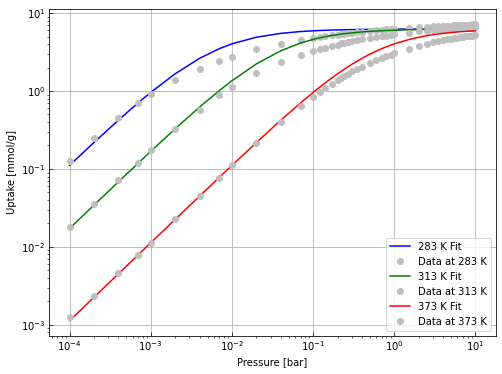

In [45]:
test.plot(logplot=True)

As expected due to the henry regime constraint, the model fits well in the low pressure region but fails in the high pressure region. We can try this dataset with the dual site Langmuir (DSL) isotherm model fitting with and without constraints as Zeolite 13X is known to fit well to DSL. We already know the henry regime of this dataset so we will not display it.

In [46]:
test = IsothermFit(df1, temps, key_pressures, key_uptakes, 'dsl', compname='CO2')
test.fit()




---- Component CO2 fitting results -----
   T (K)  q1 (mmol/g)  q2 (mmol/g)  b1 (1/bar)  b2 (1/bar)  R squared  \
0    283     2.763994     4.393422    2.588971  189.715786   0.997970   
1    313     2.830558     3.895318    1.175449   35.804315   0.999567   
2    373     2.956219     3.091039    0.304449    3.241957   0.999966   

        MSE  
0  0.009321  
1  0.002105  
2  0.000124  
_______________________________________________________________________
Heat of adsorption for site A:-20.95 kJ/mol. 
R sq of Van't Hoff: 0.9995
_______________________________________________________________________
Heat of adsorption for site B:-39.61 kJ/mol. 
R sq of Van't Hoff: 0.9999


Now for the constrained fitting:

In [35]:
test = IsothermFit(df1, temps, key_pressures, key_uptakes, 'dsl', compname='CO2')
test.fit(cond=True)

Fitting aborted! Try changing lmfit fitting method (default is "leastsq") by passing it as an argument in .fit() i.e. meth="tnc".
Recommended "tnc" or "nedler"



CO2 shows the highest approx. qsat(total) of 7.1 mmol/g
This will be used as component A
_________________________CO2 RESULTS_____________________________
 


UnboundLocalError: local variable 'dsl_result' referenced before assignment

We have encountered an error! - it looks like 'leastsq', which is scipy.optimize.leastsq, doesn't work very well for this particular dataset - perhaps changing the guess values or the fitting algorithm will help. For this, meth='tnc' will be passed as a kwarg.

In [47]:
test = IsothermFit(df1, temps, key_pressures, key_uptakes, 'dsl', compname='CO2')
test.fit(cond=True, meth='tnc');

CO2 shows the highest approx. qsat(total) of 7.1 mmol/g
This will be used as component A
_________________________CO2 RESULTS_____________________________
 

Parameters found...
   Temp(K)  qmax1 (mmol/g)  qmax2 (mmol/g)    h1 (J/mol)    h2 (J/mol)  \
0      283        3.876305        3.221235 -45036.806683 -36278.531794   
1      313        3.876305        3.221235 -45036.750863 -36275.311187   
2      373        3.876305        3.221235 -45036.718411 -36275.198947   

   b01 (1/bar)   b02 (1/bar)      R sq       mse  
0     0.000001  7.924383e-07  0.997473  0.011602  
1     0.000001  6.883995e-07  0.996817  0.015481  
2     0.000001  8.037312e-07  0.999684  0.001149  


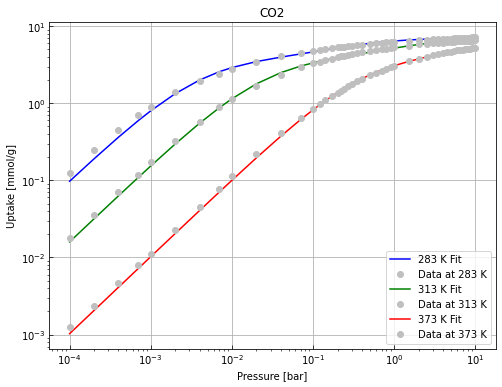

In [48]:
test.plot(logplot=True)

The constrained fitting procedure uses the one described by Farmahini et al. (2018) (https://doi.org/10.1021/acs.iecr.8b03065) who described several thermodynamically consistent fitting procedures which they used to fit the DSL isotherm model to pure-component GCMC isotherm data for CO2 and N2 on Zeolite 13X, after which they used the calculated parameters to predict binary co-adsorption isotherms. 

This package uses the third of these methods, as this was reported to show the best results out of the three. This is a multi step procedure where in the final step the most adsorbed component is fit to the temperature dependent form of the DSL isotherm model and the rest of the other components are fit to the temperature dependent form of the single site Langmuir isotherm model.

Note: 
Because the dsl constrained fitting procedure contains multiple steps for more than one components, custom bounds for this model are a work in progress and do not currently work.


### 3. The .plot_emod() method
***
The Farmahini et al. fitting procedure also included the extended dsl model for predicting co-adsorption. This is demonstrated below.

To start off, we import another set of datasets for Nitrogen. The keys for pressure and uptakes must be the same for both component datasets. We create an instance of the class by importing the dataframes and component names (optional) as lists.

The temps, key_pressures and key_uptakes variables will be re-used as they are the same for this example.

In [49]:
df2 = pd.read_csv('pyIsofit/Datasets for testing/Computational Data (EPFL) N2.csv')
df_list = [df1, df2]
compnames = ['CO2', 'N2']

test = IsothermFit(df_list, temps, key_pressures, key_uptakes, 'dsl', compnames)

Now running the .fit() method with cond=True and show_henry=True


Henry regime for component CO2:
   Henry constant (mmol/(bar.g))  Upper limit (bar)  datapoints  R squared
0                    1135.469982             0.0004           3    0.99516
1                     172.973392             0.0010           5    0.99958
2                      11.306467             0.0007           4    0.99903

Henry regime for component N2:
   Henry constant (mmol/(bar.g))  Upper limit (bar)  datapoints  R squared
0                       0.326919                0.7          26    0.99916
1                       0.170289                1.5          30    0.99909
2                       0.064547                5.5          38    0.99908
CO2 shows the highest approx. qsat(total) of 7.1 mmol/g
This will be used as component A
_________________________CO2 RESULTS_____________________________
 

Parameters found...
   Temp(K)  qmax1 (mmol/g)  qmax2 (mmol/g)    h1 (J/mol)    h2 (J/mol)  \
0      283        3.876305        3.221235 -45036.806683 -36278.531794   
1      31

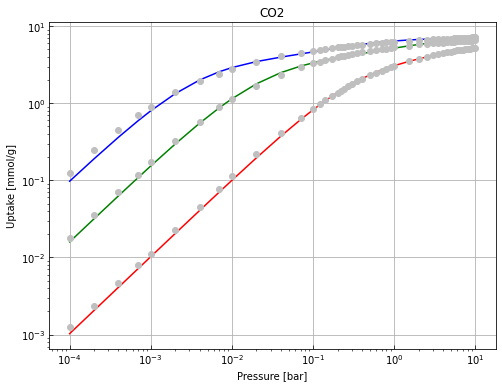

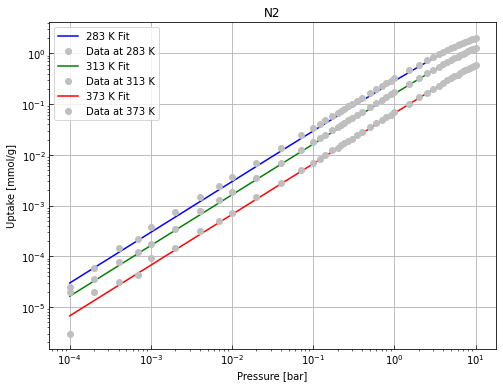

In [50]:
test.fit(cond=True, show_hen=True, meth='tnc')
test.plot(logplot=True)

Now that we have fittings for CO2 and N2, we can predict co-adsorption using .plot_emod(). This requires knowledge of the mole fractions of each component in the mixture - this is inputted as a list. Currently the only supported extended model is the 'extended dsl' model so the ext_model parameter can be ignored.

The ';' is to hide the cell output witin JN however .plot_emod() returns a dictionary of the co-adsorption uptake results for each dataset.

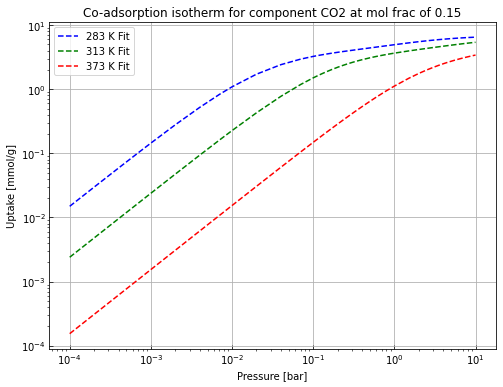

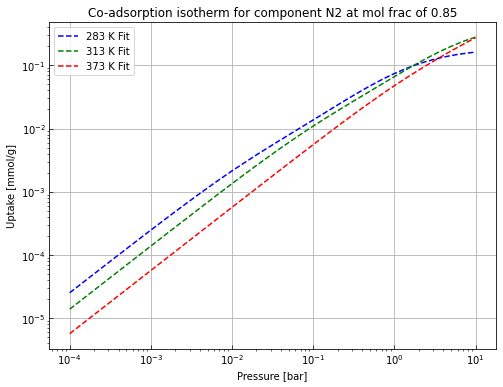

In [51]:
test.plot_emod(logplot=True, yfracs=[0.15, 0.85]);

### 4. the .save() method
***
This simply saves the results from the dataframes for henry and fitting results as a .csv or .json file. 

For some reason this does not currently work, possibly due to some changes with the directory - I will try to fix this asap.